In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from find_object_utils import *
from __future__ import division

##Template Matching

In [3]:
img = cv2.imread('images/tobii/border/frames/dark_dots/frame200.bmp')
plt.imshow(img);

In [ ]:
temp = cv2.imread('images/display/1.jpeg')
ratio = (temp.shape[1]/temp.shape[0])/(16/10)
temp = cv2.resize(temp, (temp.shape[1], int(temp.shape[0]*ratio)))
plt.imshow(temp);

In [ ]:
res = cv2.matchTemplate(img, temp, cv2.cv.CV_TM_SQDIFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
match_loc = min_loc

In [ ]:
plt.imshow(res);

In [ ]:
found = img.copy()
rect_pt = (match_loc[0]+temp.shape[1], match_loc[1]+temp.shape[0])
cv2.rectangle(found, match_loc, rect_pt, (255,0,255), 10)
plt.imshow(found);

##Feature Matching

Write frames to disk

In [8]:
vid = cv2.VideoCapture('images/feature_matching/vid_tobii.mp4')

i = 0
while(vid.isOpened()):
    ret, frame = vid.read()
    if ret:
        if i%100 == 0:
            cv2.imwrite('images/feature_matching/frames/vid_tobii/frame%i.bmp'%(i), frame)
        i += 1
    else:
        break


vid.release()

## Frame-level finding
Testing object finding on individual frames from a movie

In [39]:
img1 = cv2.imread('images/feature_matching/match.jpeg', 0)
img2 = cv2.imread('images/feature_matching/frames/vid_tobii/frame400.bmp', 0)
MIN_MATCH_COUNT = 10

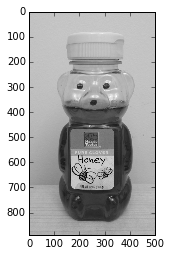

In [40]:
plt.imshow(img1, 'gray');

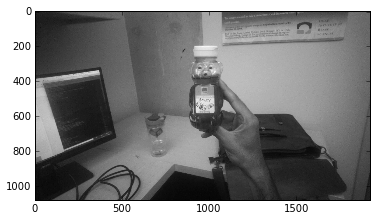

In [41]:
plt.imshow(img2, 'gray');

In [42]:
sift = cv2.SIFT()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [43]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [44]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    box_img = img2.copy()
    cv2.polylines(box_img,[np.int32(dst)],True,255,3)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

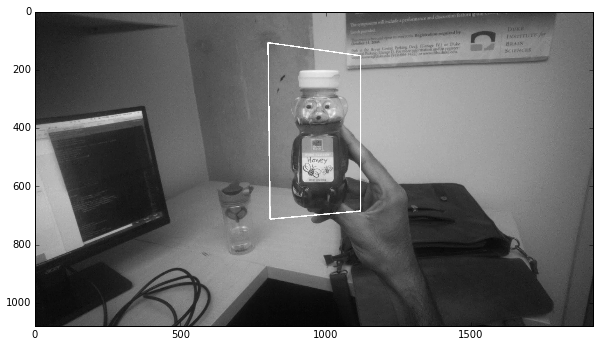

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(box_img, 'gray');

In [50]:
cv2.imwrite('images/feature_matching/box.jpg', box_img)

True

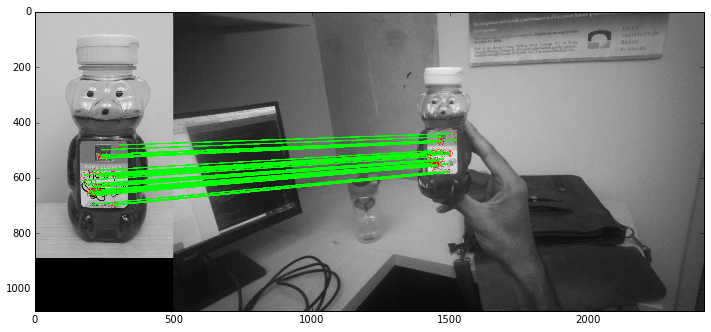

In [46]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = drawMatches(img1,kp1,img2,kp2,good, matchesMask)
plt.figure(figsize=(12,12))
plt.imshow(img3);

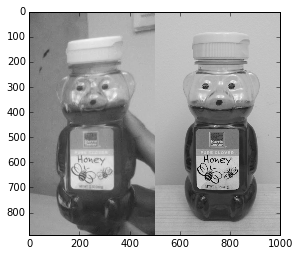

In [47]:
trans_img = cv2.warpPerspective(img2.astype('float32'), np.linalg.inv(M).astype('float32'), img1.shape[::-1])
plt.imshow(np.hstack((trans_img, img1)), "gray");

###Function Check

In [2]:
img1 = cv2.imread('images/feature_matching/match.jpeg', 0)
img2 = cv2.imread('images/feature_matching/frames/vid_phone/frame400.bmp', 0)
MIN_MATCH_COUNT = 10

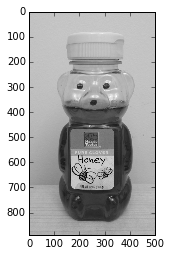

In [6]:
plt.imshow(img1, 'gray');

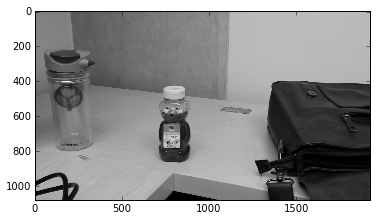

In [7]:
plt.imshow(img2, 'gray');

In [3]:
M = object_find(img1, img2, MIN_MATCH_COUNT)

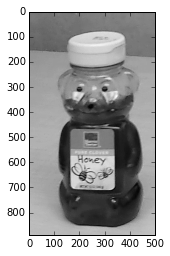

In [4]:
trans_img = cv2.warpPerspective(img2.astype('float32'), M.astype('float32'), img1.shape[::-1])
plt.imshow(trans_img, 'gray');